In [3]:
# Importing necessary packages

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import json

import pyspark
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.types import *
from pyspark.sql.functions import *

In [4]:
spark_session = SparkSession.builder\
        .master("spark://192.168.2.156:7077") \
        .appName("Group 6 project")\
        .config("spark.dynamicAllocation.enabled", True)\
        .config("spark.dynamicAllocation.shuffleTracking.enabled",True)\
        .config("spark.shuffle.service.enabled", False)\
        .config("spark.dynamicAllocation.executorIdleTimeout","30s")\
        .config("spark.executor.cores", 16)\
        .config("spark.cores.max", 64)\
        .config("spark.driver.port",9999)\
        .config("spark.blockManager.port",10005)\
        .config("spark.hadoop.fs.defaultFS", "hdfs://192.168.2.156:9000")\
        .getOrCreate()

sqlContext = SQLContext(spark_session.sparkContext)
spark_session.sparkContext.setLogLevel("ERROR")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/15 18:55:46 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
/home/ubuntu/.local/lib/python3.10/site-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [5]:
# Load JSON as a Spark DataFrame
df = spark_session.read.json("hdfs://192.168.2.156:9000/data/reddit/corpus-webis-tldr-17.json")

In [ ]:
df.show() #Works!

# Task 1: Reading level in subreddits
First, we analyse the language level using Flesch–Kincaid grade level.

In [6]:
# Making a new df for analyzing the reading level

# Preprocessing

# Splitting sentences
df_spell = df.select("subreddit", split(df["content"], r'[.!?]').alias("content_split"))

# Splitting words, removing punctuation and empty strings
df_words = df_spell.withColumn("content_split", expr("""transform(content_split, x -> filter(transform(split(x, ' '), word -> trim(regexp_replace(regexp_replace(word, '[\\n]', ''), '[,\\.\\!\\?:\\*\\(\\)]', ''))), word -> word != ''))"""))

df_words = df_words.filter(size(df_words["content_split"]) > 0)  # Remove empty rows

df_words.first()
print(f"The length is {df_words.count()}")

[Stage 2:======================================================>(146 + 1) / 147]

The length is 3848330


In [11]:
# Define the syllable count function
def syllable_count(word):
    # If the word is not alphabetic, return 0 (e.g., for numbers or symbols)
    if not word.isalpha():
        return 0
    
    word = word.lower()  # Ensure the word is in lowercase
    count = 0
    vowels = "aeiou"
    
    # Check the first letter
    if word[0] in vowels:
        count += 1
    
    # Count syllables in the rest of the word
    for index in range(1, len(word)):
        if word[index] in vowels and word[index - 1] not in vowels:
            count += 1
    
    # Special case: Subtract 1 if the word ends with 'e' (unless 'e' is preceded by a vowel)
    if word.endswith("e") and (len(word) > 1 and word[-2] not in vowels):
        count -= 1
    
    # Ensure that a word has at least one syllable
    if count == 0:
        count += 1
    
    # Limit reasonable syllable count (this can be adjusted based on context)
    if count < 10:  # Reasonable cap for most English words
        return count
    else:
        return 1

# Define the function to calculate the reading level (Flesch-Kincaid)
def reading_level(list_of_sentences):
    # Flatten the list of lists into a single list of words

    total_words = 0
    total_syllables = 0
    total_sentences = 0  # Since each row represents one sentence (as split by punctuation)

    # Iterate over each word in the flattened list and calculate total words and syllables
    for sentence in list_of_sentences:
        
        words_in_sentence = 0
        syllables_in_sentence = 0
        
        # Iterate over each word in the sentence
        for word in sentence:
            # Skip empty strings or unwanted characters (e.g., newlines)
            word = word.strip(",. !?:*()[]")
            if word.isalpha():  # Ensure the word is alphabetic
                words_in_sentence += 1  # Increment word count
                syllables_in_sentence += syllable_count(word)  # Add syllables for the word
                
        if words_in_sentence > 0 and words_in_sentence < 35: # Only add reasonable values
            total_words += words_in_sentence
            total_syllables += syllables_in_sentence
            total_sentences += 1

    # Avoid division by zero
    if total_words == 0 or total_sentences == 0:
        return 0

    # Calculate the Flesch-Kincaid readability index with the formula:
    # Reading Level = 0.39 * (total_words / total_sentences) + 11.8 * (total_syllables / total_words) - 15.59
    level = 0.39*(total_words / total_sentences) + 11.8*(total_syllables / total_words) - 15.59
    if level < -3.5:
        raise ValueError(f"Level too low ({level}). Total words: {total_words}, Total sentences: {total_sentences}, Total syllables: {total_syllables}")
    else:
        return level

# # Define the UDF for reading level calculation
# def reading_level_udf(sentence_list):
#     return float(reading_level(sentence_list))

# Register the UDF
udf_reading_level = udf(lambda sentence_list: reading_level(sentence_list))

# Apply the UDF to calculate the reading level for each row
df_with_reading_level = df_words.withColumn("reading_level", udf_reading_level("content_split"))

# Show the result
df_with_reading_level.select("subreddit", "reading_level").show(truncate=False)

+---------------------+------------------+
|subreddit            |reading_level     |
+---------------------+------------------+
|math                 |7.163333333333334 |
|funny                |8.155000000000005 |
|Borderlands          |6.973302325581397 |
|gamingpc             |5.933965517241379 |
|Diablo               |7.090000000000003 |
|RedditLaqueristas    |5.076363636363638 |
|apple                |0                 |
|apple                |6.8530126582278506|
|RedditFilmsProduction|5.388242753623189 |
|AbandonedPorn        |2.878922670191674 |
|atheism              |4.383823529411767 |
|quotes               |2.4700000000000024|
|AskReddit            |6.780000000000001 |
|personalfinance      |6.614189189189187 |
|Animals              |2.3121403508771934|
|leagueoflegends      |3.833307240704503 |
|AskReddit            |6.014000000000003 |
|videos               |6.571069725187371 |
|trees                |11.169411764705881|
|Games                |8.931724137931035 |
+----------

In [18]:
# Show a couple of rows for debug

df_with_reading_level.show()

[Stage 17:>                                                         (0 + 1) / 1]

+--------------------+--------------------+------------------+
|           subreddit|       content_split|     reading_level|
+--------------------+--------------------+------------------+
|                math|[[I, think, it, s...| 7.163333333333334|
|               funny|[[Art, is, about,...| 8.155000000000005|
|         Borderlands|[[Ask, me, what, ...| 6.973302325581397|
|            gamingpc|[[In, Mechwarrior...| 5.933965517241379|
|              Diablo|[[You, are, talki...| 7.090000000000003|
|   RedditLaqueristas|[[All, but, one, ...| 5.076363636363638|
|               apple|[[I, could, give,...|                 0|
|               apple|[[So, you're, say...|6.8530126582278506|
|RedditFilmsProduc...|[[I, love, this, ...| 5.388242753623189|
|       AbandonedPorn|[[Theres, an, ent...| 2.878922670191674|
|             atheism|[[FALSE], [Eviden...| 4.383823529411767|
|              quotes|[[If, the, number...|2.4700000000000024|
|           AskReddit|[[Yeah, but, most...| 6.780000000

In [19]:
df_average_grade = df_with_reading_level.groupBy("subreddit").agg(avg("reading_level").alias("Avg_reading_level"))
df_average_grade.take(10)

[Stage 18:=====================================================>(146 + 1) / 147]

+--------------------+------------------+
|           subreddit| Avg_reading_level|
+--------------------+------------------+
|               anime| 5.998241877742436|
|          MensRights| 6.054316177684127|
|          QuotesPorn| 6.157130259510808|
|        marvelheroes| 5.162728687103215|
|              travel| 5.539819842156435|
|          MLBTheShow| 5.011567259114122|
| UnresolvedMysteries| 5.831162140059496|
|            lacrosse|4.7962534036436635|
|        SaltLakeCity| 5.181134873517809|
|londonfootballmeetup|4.3935855928567635|
|           kitchener| 5.345188758573238|
|            Whippets| 5.150883939554659|
|          costa_rica| 5.346048184160238|
|          WahoosTipi| 4.979772219527025|
|        couchsurfing| 5.202664446927588|
|     youtubecomments| 5.222606696369959|
|             DRKCoin| 6.048768757611999|
|          television|5.8376548492367215|
|    fatpeoplestories| 4.400446158342351|
|          treedibles| 5.159450048057807|
+--------------------+------------

In [21]:
# Top 10 subreddits with the worst (lowest) reading level
top_10_best = df_average_grade.orderBy("avg_reading_level", ascending=True).limit(10)

# Top 10 subreddits with the best (highest) reading level
top_10_worst = df_average_grade.orderBy("avg_reading_level", ascending=False).limit(10)

print("Top 10 best Subreddits:")
top_10_worst.select("subreddit", "avg_reading_level").show(truncate=False)

print("Top 10 worst Subreddits:")
top_10_best.select("subreddit", "avg_reading_level").show(truncate=False)

Top 10 best Subreddits:


+-----------------+------------------+
|subreddit        |avg_reading_level |
+-----------------+------------------+
|Webkinz          |27.597142857142853|
|dsjkfhrewayufiejk|22.820000000000004|
|tacocovers       |20.980000000000008|
|faget            |20.590000000000007|
|spacecats        |20.200000000000006|
|italians         |19.27181818181818 |
|mainstream_alien |18.170000000000005|
|AskRo            |18.075555555555557|
|helsinki         |16.916975308641977|
|ClannadDiscussion|16.58534314560594 |
+-----------------+------------------+

Top 10 worst Subreddits:


[Stage 30:=====================================================>(146 + 1) / 147]

+------------------+-------------------+
|subreddit         |avg_reading_level  |
+------------------+-------------------+
|knightonline      |-3.3999999999999986|
|reddos            |-3.3999999999999986|
|Chidd             |-3.3999999999999986|
|YubaCity          |-3.3999999999999986|
|askbroscience     |-3.3999999999999986|
|CompetitiveYugioh |-3.3999999999999986|
|theoryofpropaganda|-3.3999999999999986|
|Ravens_War_Room   |-3.3999999999999986|
|ConTalks          |-3.3999999999999986|
|discoverynews     |-3.3999999999999986|
+------------------+-------------------+



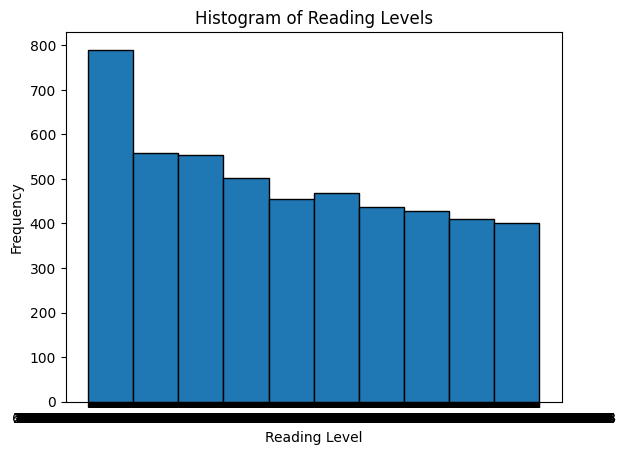

In [23]:
pdf = df_with_reading_level.select("reading_level").limit(5000).toPandas()

import matplotlib.pyplot as plt
# Plot histogram
plt.hist(pdf["reading_level"], bins=10, edgecolor="black")
plt.xlabel("Reading Level")
plt.ylabel("Frequency")
plt.title("Histogram of Reading Levels")
plt.show()

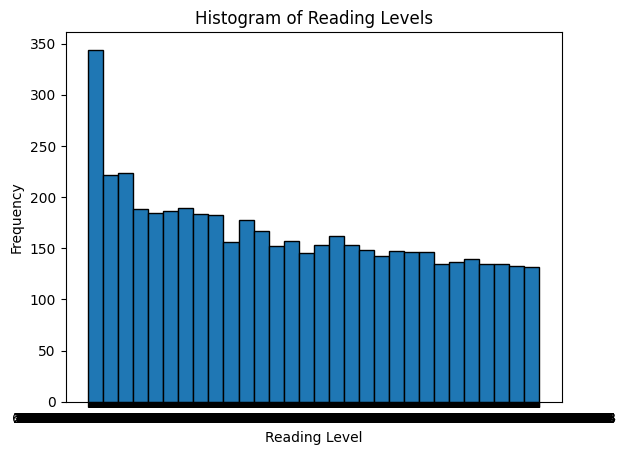

In [24]:

# Plot histogram
plt.hist(pdf["reading_level"], bins=30, edgecolor="black")
plt.xlabel("Reading Level")
plt.ylabel("Frequency")
plt.title("Histogram of Reading Levels")
plt.show()

In [19]:
spark_session.stop()